# CUDA Community Meetup Talk Demo

15 February 2022

![Numba and CUDA logos](title-image.png)

create_fractal() execution time: 0.410858151037246 seconds


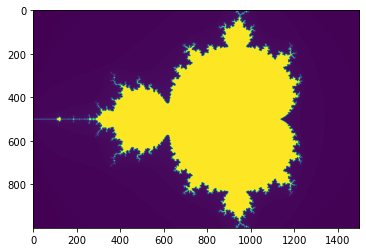

In [2]:
# Imports
from matplotlib.pylab import imshow, show
from time import perf_counter
from numba import jit
import numpy as np

# Parameters
max_iters = 20
min_x, max_x, min_y, max_y = (-2.0, 1.0, -1.0, 1.0)
image_size = (1000, 1500)


# Mandelbrot functions

@jit
def mandel(x, y):
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal():
    image = np.zeros(image_size, dtype=np.uint8)
    
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag)
            image[y, x] = color
    
    return image

            
# Call JITted function

start = perf_counter()
image = create_fractal()
end = perf_counter()

print(f"create_fractal() execution time: {end - start} seconds")

imshow(image)
show()

In [3]:
# Call JITted function
start = perf_counter()
create_fractal()
end = perf_counter()

print(f"create_fractal() execution time: {end - start} seconds")

create_fractal() execution time: 0.058084208983927965 seconds


In [4]:
start = perf_counter()
create_fractal.py_func()
end = perf_counter()

print(f"create_fractal() Python-only execution time: {end - start} seconds")

create_fractal() Python-only execution time: 0.5710441849660128 seconds


* Approx 10x speedup in this case.
* Typical speedups around 10x - 1/200x over Pure Python

### Google Colab

https://colab.research.google.com: Select **Runtime**, select **Change runtime type**, select **Hardware accelerator** and set to **GPU**

- Pros:
  - Free
  - Uses Jupyter Notebooks
- Cons:
  - Limited runtime, customizability, old Numba version (0.51.2)
  - Availability of GPUs can be limited
  - Uses Jupyter Notebooks
      

### GPU in your own machine

Pros:

- Consistent availability
- Can install / run anything on your own machine
- Can use the debugger (cuda-gdb)

Cons:

- May be lower performance (especially for 64-bit floating point) than pro-grade hardware like T4, RTX x000
- Have to maintain it yourself
- Availability a little difficult for high-end GPUs at the moment

Recommendation for getting started / development:

- GTX 10x0: Old enough to be available at reasonable cost, most Numba CUDA features supported by it
  - GTX 1050 needs no extra power connector, just a PCIe x16 slot
- Good enough for development / debugging
- Move code to higher-performance system later

<img alt="GTX 1050 Ti Founders edition GPU" src="gtx-1050-ti.webp" width="400">

# Demo: Diffusion code example

This example provides a short illustration of how to use Numba with the CPU parallel and CUDA targets.

The example function is very simple:
* We begin with a Gaussian hump of tracer.
* A finite-difference kernel diffuses the tracer over many iterations.

### Imports

In [5]:
from numba import cuda, njit, prange
import numba
import numpy as np
import pylab
from time import perf_counter

In [6]:
%matplotlib inline

In [7]:
print(numba.__version__)

0.56.0dev0+221.g0fc9ff794.dirty


In [8]:
cuda.detect()

Found 2 CUDA devices
id 0      b'Quadro RTX 8000'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 21
                                    UUID: GPU-e6489c45-5b68-3b03-bab7-0e7c8e809643
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
id 1      b'Quadro RTX 8000'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 45
                                    UUID: GPU-499943e5-f155-f631-f44c-a61ca5995fd2
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	2/2 devices are supported


True

In [9]:
with open('/proc/cpuinfo', 'r') as f:
    print(f.read())

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
stepping	: 4
microcode	: 0x2006b06
cpu MHz		: 1200.132
cache size	: 19712 KB
physical id	: 0
siblings	: 12
core id		: 1
cpu cores	: 6
apicid		: 2
initial apicid	: 2
fpu		: yes
fpu_exception	: yes
cpuid level	: 22
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 cdp_l3 invpcid_single pti intel_ppin ssbd mba ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm cqm mpx rdt_a avx512

### Run parameters

These are chosen for relatively quick execution, but with large enough data to make efficient use of CUDA.
* 10,000 iterations.
* A grid of 1,000 by 1,000 points.

In [10]:
ITERATIONS = 20000
POINTS = 1000

### Generation of initial conditions

* Creates a hump of tracer.
* We use Numba's `@njit` decorator to speed this up
  - Compiles the Python to native code.
  - Single-threaded.

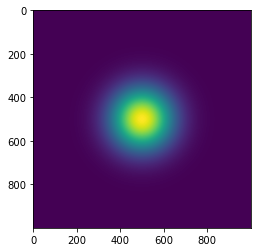

In [11]:
@njit
def gauss2d(x, y): 
    grid = np.empty_like(x)

    a = 1.0 / np.sqrt(2 * np.pi)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            grid[i, j] = a * np.exp(-(x[i, j]**2 / 2 + y[i, j]**2
                                      / 2)) 

    return grid


X = np.linspace(-5, 5, POINTS)
Y = np.linspace(-5, 5, POINTS)
x, y = np.meshgrid(X, Y)

z = gauss2d(x, y)

pylab.imshow(z)
pylab.show()

## Python version

We don't actually run this, because it will take too long.

Having the function definition here illustrates our starting point.

In [12]:
def smooth(x0, x1):
    for i in range(1, x0.shape[0] - 1): 
        for j in range(1, x0.shape[1] - 1): 
            x1[i, j] = 0.25 * (x0[i, j - 1] + x0[i, j + 1] +
                               x0[i - 1, j] + x0[i + 1, j]) 

def run_python():
    z0 = z.copy()
    z1 = np.zeros_like(z0)
    
    start = perf_counter()

    for i in range(ITERATIONS):
        if (i % 2) == 0:
            smooth(z0, z1)
        else:
            smooth(z1, z0)

    end = perf_counter()

    time_python = end - start
    return z0, time_python


# Not running because it will take too long!
# z_python, time_python = run_python()
# pylab.imshow(z_python)
# pylab.show()

## CPU JIT

We parallelise execution on the CPU, for better performance:
* Passing `parallel=True` to the `@njit` decorator
* Using a `prange` instead of a `range` to indicate how to parallelize.

Benchmarking the CPU implementation requires a little care:

* The first call to the `smooth_jit()` function will trigger JIT compilation of the function which is quite costly in comparison to an iteration (a few hundred milliseconds, perhaps)
  * So, we make a "dummy call" before starting our timed loop, so the JIT compilation is out of the way.

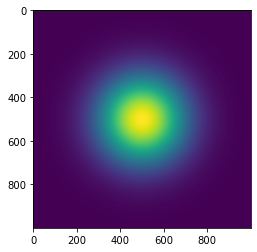

In [13]:
@njit(parallel=True)
def smooth_jit(x0, x1):
    for i in prange(1, x0.shape[0] - 1): 
        for j in range(1, x0.shape[1] - 1): 
            x1[i, j] = 0.25 * (x0[i, j - 1] + x0[i, j + 1] +
                               x0[i - 1, j] + x0[i + 1, j]) 


def run_cpu_jit():
    z0 = z.copy()
    z1 = np.zeros_like(z0)

    # Warm up JIT
    smooth_jit(z0, z1) 

    start = perf_counter()

    for i in range(ITERATIONS):
        if (i % 2) == 0:
            smooth_jit(z0, z1) 
        else:
            smooth_jit(z1, z0) 

    end = perf_counter()


    time_cpu = end - start
    return z0, time_cpu

z_cpu, time_cpu = run_cpu_jit()

pylab.imshow(z_cpu)
pylab.show()

## CUDA JIT

Parallel implementation on the CPU requires some more changes:

* Use of the `@cuda.jit` decorator.
* The `for` loops are "flattended" - `smooth_cuda()` is invoked by many threads.
  - Each thread gets its index `(i, j)` from `cuda.grid(2)` (for a 2D grid).
  - We check this kernel's indices are in the bounds
    - (the interior of the domain)
* The number of threads to launch (the grid and block dimensions) are computed.
  - We use a fixed size block here, and work out how many we need based on the input size.
  - We could also use a loop inside the `smooth_cuda` function (a *grid-stride loop*) but don't here for simplicity.
  
Benchmarking the CUDA implementation needs a little more care:

* We copy data over to the device first.
  * If we don't do this, we end up creating implicit copies every time the kernel is launched.
  * Implicit copies insert a lot of synchronization points and slow down execution considerably.
* We call `cuda.synchronize()` before ending timing.
  * Kernel launches are asynchronous, so if we don't do this the GPU still can have work to do when we stop the timer.

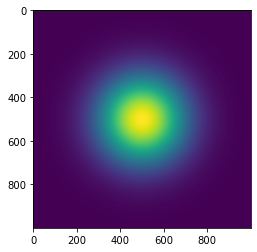

In [14]:
@cuda.jit
def smooth_cuda(x0, x1):
    i, j = cuda.grid(2)

    i_in_bounds = (i > 0) and (i < (x0.shape[0] - 1))
    j_in_bounds = (j > 0) and (j < (x0.shape[1] - 1))

    if i_in_bounds and j_in_bounds:
        x1[i, j] = 0.25 * (x0[i, j - 1] + x0[i, j + 1] +
                           x0[i - 1, j] + x0[i + 1, j])


def run_cuda_jit():
    # Copy to device
    z0 = cuda.to_device(z)
    z1 = cuda.device_array_like(np.zeros_like(z))

    # Warm up JIT
    blockdim = (16, 16)
    griddim = ((z0.shape[0] // blockdim[0]) + 1, (z0.shape[1] // blockdim[1]) + 1)
    smooth_cuda[griddim, blockdim](z0, z1)

    start = perf_counter()

    for i in range(ITERATIONS):
        if (i % 2) == 0:
            smooth_cuda[griddim, blockdim](z0, z1)
        else:
            smooth_cuda[griddim, blockdim](z1, z0)

    # Make sure the GPU is finished before we stop timing
    cuda.synchronize()
    end = perf_counter()

    
    time_cuda = end - start
    return z0.copy_to_host(), time_cuda

z_cuda, time_cuda = run_cuda_jit()

pylab.imshow(z_cuda)
pylab.show()

## Check and compare results

Hopefully the difference between the solutions (CPU and CUDA) should look fairly small:

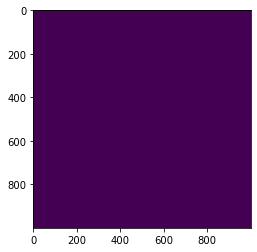

In [15]:
diff = np.abs(z_cpu - z_cuda)
pylab.imshow(diff)
pylab.show()

## Compare performance

Before giving any performance measurements, it's always a good idea to (somewhat) rigorously check correctness:

In [16]:
# Ensure the solutions are reasonably close
np.testing.assert_allclose(z_cpu, z_cuda)

# If so, print out execution times
print(f"CPU time: {time_cpu:2.2f} seconds")
print(f"CUDA time: {time_cuda:2.2f} seconds")

CPU time: 12.99 seconds
CUDA time: 1.22 seconds


# Further resources / next steps

Learning how to use Numba:

* A recent and comprehensive course on using Numba with CUDA: https://github.com/numba/nvidia-cuda-tutorial
* A 5-minute guide to Numba in the Numba docs: https://numba.readthedocs.io/en/latest/user/5minguide.html

Learning more about Numba:
* The life of a Numba kernel: https://medium.com/rapids-ai/the-life-of-a-numba-kernel-a-compilation-pipeline-taking-user-defined-functions-in-python-to-cuda-71cc39b77625
* Numba documentation: https://numba.readthedocs.io/en/latest/

Learning about CUDA and GPUs in general:

* CUDA C Programming Guide: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html
* An even easier introduction to CUDA: https://developer.nvidia.com/blog/even-easier-introduction-cuda/

Discussion / help:

- [Numba Gitter channel](https://gitter.im/numba/numba) - good for quick questions and interactive discussion
- [Numba Discourse](https://numba.discourse.group) - better for more in-depth questions
- [Numba Issue tracker](https://github.com/numba/numba/issues) - better for reporting bugs and making feature requests - not usually the first port of call